In [30]:
#####Factorization meets the item Embedding#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns

#np.random.seed(98537)

(array([  4.,  15.,  70., 182., 341., 447., 632., 615., 602., 495., 464.,
        333., 269., 183., 137.,  79.,  53.,  34.,  13.,  16.,   4.,   8.,
          0.,   1.,   3.]),
 array([ 14.  ,  23.96,  33.92,  43.88,  53.84,  63.8 ,  73.76,  83.72,
         93.68, 103.64, 113.6 , 123.56, 133.52, 143.48, 153.44, 163.4 ,
        173.36, 183.32, 193.28, 203.24, 213.2 , 223.16, 233.12, 243.08,
        253.04, 263.  ]),
 <a list of 25 Patch objects>)

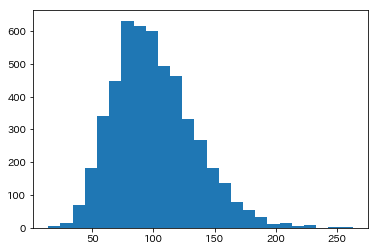

In [31]:
####データの生成####
##データの設定
s = 2
k = 10
k_vec = np.repeat(1, k)
hh = 5000
item = 3000
pt = np.random.poisson(np.random.gamma(10.0, 1/0.1, hh), hh)
hhpt = np.sum(pt)
plt.hist(pt, bins=25)

In [32]:
##IDとインデックスの設定
#IDの設定
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
index = np.array(range(hhpt))
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = index[d_id==i]
d_dt = sparse.coo_matrix((np.repeat(1, hhpt), (d_id, range(hhpt))), shape=(hh, hhpt)).tocsr()   #スパース行列の設定

In [33]:
#素性ベクトルを生成
k1 = 5; k2 = 6; k3 = 5
x1 = np.abs(np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1)))
x2 = np.zeros((hhpt, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, hhpt)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.concatenate((np.repeat(1, hhpt)[:, np.newaxis], x1, x2, x3), axis=1)   #すべての説明変数を結合
x_col = x.shape[1]

In [34]:
##アイテムの割当を生成
#トピック割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.225, item), topic)
theta = np.random.dirichlet(np.repeat(0.5, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[d_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(item))
item_dt = sparse.coo_matrix((np.repeat(1, hhpt), (item_id, range(hhpt))), shape=(item, hhpt)).tocsr()   #スパース行列の設定
item_n = np.array(np.sum(item_dt, axis=1)).reshape(-1)

#アイテムのインデックスを作成
item_list = [j for j in range(item)]
for j in range(item):
    item_list[j] = np.array(np.where(item_id==j)[0], dtype="int")

0
1000
2000
3000
4000


In [35]:
##応答変数を生成
rp = 0
while True:
    rp = 0

    ##モデルパラメータを生成
    #事前分布のパラメータ
    alpha_u = np.repeat(0, k)
    alpha_v = np.repeat(0, k)
    tau = np.array([1.5])
    Cov_u = np.diag(np.repeat(0.5, k))
    Cov_v1 = np.diag(np.repeat(0.5, k))
    Cov_v2 = np.diag(np.repeat(0.5, k))
    alpha_ut = alpha_u.copy(); alpha_vt = alpha_v.copy()
    taut = tau.copy(); Cov_ut = Cov_u.copy(); Cov_vt1 = Cov_v1.copy(); Cov_vt2 = Cov_v2.copy()
    
    #MFのパラメータを生成
    beta = np.append(-1.0, np.random.normal(0, 0.7, x_col-1))
    theta = np.random.multivariate_normal(alpha_u, Cov_u, hh)
    Sigma = np.array([1.0])
    betat = beta.copy(); thetat = theta.copy(); Sigmat = Sigma.copy()

    #item embeddingのパラメータ
    alpha = np.random.normal(-0.3, tau, item)
    gamma = np.random.multivariate_normal(np.repeat(0, k), Cov_v1, item)
    omega = np.random.multivariate_normal(np.repeat(0, k), Cov_v2, item)
    alphat = alpha.copy(); gammat = gamma.copy(); omegat = omega.copy()

    ##アイテム購買応答変数を生成
    #期待値を設定
    mu1 = np.dot(x, beta) + np.sum(theta[d_id, ] * gamma[item_id, ], axis=1)

    #正規分布からバイナリー変数を生成
    u1 = np.random.normal(mu1, Sigma, hhpt)
    y1 = np.array(u1 > 0, dtype="int")
    y_vec1 = y1[:, np.newaxis]
    
    #break条件
    print(np.mean(y1))
    if (np.mean(y1) > 0.2) & (np.mean(y1) < 0.4):
        break

0.42655464595731285
0.6151144280787598
0.5022961323369148
0.41937836077070356
0.24721724699211645


In [36]:
##item Embeddingの応答変数を生成
#データの設定
n = 5
no = np.arange(item)
rate = item_n / np.sum(item_n)
y2_list = [j for j in range(item)]
Embedding_id_list1 = [j for j in range(item)]
Embedding_id_list2 = [j for j in range(item)]

#アイテムの共起関係を生成
for j in range(item):
    if j%1000==0:
        print(j)
    random_id = np.random.choice(no, item*n, p=rate)
    mu2 = alpha[j] + alpha[random_id] + np.sum(gamma[np.repeat(j, item*n), ] * omega[random_id, ], axis=1)
    u2 = np.random.normal(mu2, Sigma, item*n)
    y2 = np.array(u2 > 0, dtype="int")
 
    #負例サンプリングでアイテムを生成
    index_y1 = np.array(np.where(y2==1)[0], dtype="int")
    index_y0 = np.array(np.where(y2==0)[0], dtype="int")
    y2_list[j] = np.append(np.repeat(1, item_n[j]), np.repeat(0, item_n[j]*s))
    Embedding_id_list1[j] = np.repeat(j, y2_list[j].shape[0])
    Embedding_id_list2[j] = np.append(random_id[np.random.choice(index_y1, item_n[j], replace=True)], 
                                      random_id[np.random.choice(index_y0, item_n[j]*s, replace=True)])

0
1000
2000


In [37]:
#リストを変換
Embedding_id1 = np.array(list(itertools.chain(*[Embedding_id_list1[j] for j in range(item)])))
Embedding_id2 = np.array(list(itertools.chain(*[Embedding_id_list2[j] for j in range(item)])))
y2 = np.array(list(itertools.chain(*[y2_list[j] for j in range(item)])))
N = y2.shape[0]
del Embedding_id_list1, Embedding_id_list2, y2_list

In [38]:
#Embeddingのインデックスを設定
Embedding_list1 = [j for j in range(item)]
Embedding_list2 = [j for j in range(item)]
for j in range(item):
    Embedding_list1[j] = np.array(np.where(Embedding_id1==j)[0], dtype="int")
    Embedding_list2[j] = np.array(np.where(Embedding_id2==j)[0], dtype="int")

In [39]:
##テストデータの生成



In [40]:
####ギブスサンプリングでFactorization meets the item Embeddingを推定####
##切断正規分布の乱数を発生させる関数
def rtnorm(mu, sigma, a, b, n):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    return norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)

In [41]:
##アルゴリズムの設定
LL1 = -100000000   #対数尤度の初期値
R = 2000
keep = 2  
iter = 0
burnin = 500/keep
disp = 10

In [42]:
##事前分布の設定
#階層モデルの事前分布
delta = np.repeat(0, k)
nu = 1
V = 0.1 * np.diag(np.ones(k))
s0 = 0.1
v0 = 0.1

#素性ベクトルの事前分布
Lambda = np.repeat(0, x_col) 
kappa = np.diag(np.repeat(100, x_col))
inv_kappa = np.linalg.inv(kappa)

In [49]:
##パラメータの真値
#階層モデルの事前分布の真値
alpha_u = alpha_ut.copy()
alpha_v = alpha_vt.copy()
tau = taut.copy()
Cov_u = Cov_ut.copy()
Cov_v1 = Cov_vt1.copy()
Cov_v2 = Cov_vt2.copy()
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v1 = np.linalg.inv(Cov_v1)
inv_Cov_v2 = np.linalg.inv(Cov_v2)

#MFのパラメータの真値
beta = betat.copy()
theta = thetat.copy()
Sigma = np.array([1.0])
beta_mu = np.dot(x, beta)
uv = np.dot(theta[d_id, ] * gamma[item_id, ], k_vec)

#item embeddingのパラメータの真値
alpha1 = alphat.copy()
alpha2 = alphat.copy()
gamma = gammat.copy()
omega = omegat.copy()
vv = np.dot(gamma[Embedding_id1, ] * omega[Embedding_id2, ], k_vec)

In [72]:
##パラメータの初期値
#階層モデルの事前分布の初期値
alpha_u = np.repeat(0, k)
alpha_v = np.repeat(0, k)
tau = np.array([1.0])
Cov_u = np.diag(np.repeat(1.0, k))
Cov_v1 = np.diag(np.repeat(1.0, k))
Cov_v2 = np.diag(np.repeat(1.0, k))
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v1 = np.linalg.inv(Cov_v1)
inv_Cov_v2 = np.linalg.inv(Cov_v2)

#MFのパラメータの初期値
beta = np.dot(np.dot(np.linalg.inv(np.dot(x.T, x)), x.T), y1)
theta = np.random.multivariate_normal(alpha_u, np.diag(np.repeat(0.1, k)), hh)
Sigma = np.array([1.0])
beta_mu = np.dot(x, beta)
uv = np.dot(theta[d_id, ] * gamma[item_id, ], k_vec)

#item embeddingのパラメータの初期値
alpha1 = np.random.normal(0, 0.5, item)
alpha2 = np.random.normal(0, 0.5, item)
gamma = np.random.multivariate_normal(alpha_v, np.diag(np.repeat(0.1, k)), item)
omega = np.random.multivariate_normal(alpha_v, np.diag(np.repeat(0.1, k)), item)
vv = np.dot(gamma[Embedding_id1, ] * omega[Embedding_id2, ], k_vec)

In [73]:
##データの設定
#データの定数
XXV = np.dot(x.T, x) + inv_kappa
inv_XXV = np.linalg.inv(XXV)

#切断領域を定義
a1 = (1-y1)*(-100) + y1*0
b1 = y1*100 + (1-y1)*0
a2 = (1-y2)*(-100) + y2*0
b2 = y2*100 + (1-y2)*0

In [76]:
##サンプリング結果の格納用配列
#階層モデルの格納用配列
ALPHA_U = np.zeros((int(R/keep), k))
ALPHA_V = np.zeros((int(R/keep), k))
TAU = np.repeat(0, int(R/keep))
COV_U = np.zeros((k, k, int(R/keep)))
COV_V1= np.zeros((k, k, int(R/keep)))
COV_V2 = np.zeros((k, k, int(R/keep)))

#MFのパラメータの格納用配列
BETA = np.zeros((int(R/keep), x_col))
THETA = np.zeros((hh, k, int(R/keep)))

#item embeddingのパラメータの格納用配列
ALPHA1 = np.zeros((int(R/keep), item))
ALPHA2 = np.zeros((int(R/keep), item))
GAMMA = np.zeros((item, k, int(R/keep)))
OMEGA = np.zeros((item, k, int(R/keep)))

In [77]:
##対数尤度の基準値
#1パラメータでの対数尤度
LLst = np.sum(y1*np.log(np.mean(y1))) + np.sum((1-y1)*np.log(np.mean(1-y1)))
print(LLst)

#真値での対数尤度
mu =  np.dot(x, betat) + np.sum(thetat[d_id, ] * gammat[item_id, ], axis=1)
Prob = scipy.stats.norm.cdf(mu, 0, Sigmat)
Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
LLbest = np.sum(y1*np.log(Prob)) + np.sum((1-y1)*np.log(1-Prob))
print(LLbest)

-280708.5641265551
-133240.10060566576


In [ ]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    ##切断正規分布から潜在変数をサンプリング
    #MFの潜在変数をサンプリング
    uv = np.dot(theta[d_id, ] * gamma[item_id, ], k_vec)
    mu1 = np.dot(x, beta) + uv
    U1 = rtnorm(mu1, Sigma, a1, b1, hhpt) 

    #item embeddingの潜在変数をサンプリング
    alpha_vec1 = alpha1[Embedding_id1]
    alpha_vec2 = alpha2[Embedding_id2]
    vv = np.dot(gamma[Embedding_id1, ] * omega[Embedding_id2, ], k_vec)
    mu2 = alpha_vec1 + alpha_vec2 + vv
    U2 = rtnorm(mu2, Sigma, a2, b2, N)

    ##素性ベクトルの回帰パラメータをサンプリング
    #モデル誤差を定義
    er_y = U1 - uv 

    #多変量正規分布からパラメータをサンプリング
    beta_par = np.dot(np.dot(inv_XXV, x.T), er_y)
    beta = np.random.multivariate_normal(beta_par, Sigma*inv_XXV, 1).reshape(-1)

    ##ユーザーの特徴ベクトルをサンプリング
    #モデル誤差を定義
    beta_mu = np.dot(x, betat)
    er_y = U1 - beta_mu

    #ユーザーごとにパラメータをサンプリング
    for i in range(hh):
        #データの設定
        index = d_list[i]
        v = gamma[item_id[index], ]

        #特徴ベクトルの事後分布のパラメータ
        xy = np.dot(v.T, er_y[index])
        xxv = np.dot(v.T, v) + inv_Cov_u
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_u, alpha_u))

        #多変量正規分布から特徴ベクトルをサンプリング
        theta[i, ] = np.random.multivariate_normal(theta_par, inv_xxv, 1)

    ##アイテムの特徴ベクトルをサンプリング
    #モデル誤差の定義
    er_y1 = er_y.copy()
    er_y2 = U2 - alpha_vec1 - alpha_vec2

    #アイテムごとにパラメータをサンプリング
    for j in range(item):
        #データの設定
        index1 = item_list[j]; index2 = Embedding_list1[j]
        u1 = theta[d_id[index1], ]; u2 = omega[Embedding_id2[index2], ]

        #特徴ベクトルの事後分布のパラメータ
        xy = np.dot(u1.T, er_y1[index1]) + np.dot(u2.T, er_y2[index2])
        xxu = np.dot(u1.T, u1) + np.dot(u2.T, u2) + inv_Cov_v1
        inv_xxu = np.linalg.inv(xxu)
        gamma_par = np.dot(inv_xxu, xy + np.dot(inv_Cov_v1, alpha_v))

        #多変量正規分布から特徴ベクトルをサンプリング
        gamma[j, ] = np.random.multivariate_normal(gamma_par, inv_xxu, 1)

    ##skip gramの特徴ベクトルをサンプリング
    #skip gramごとにパラメータをサンプリング
    for j in range(item):
        #データの設定
        index = Embedding_list2[j]
        v = gamma[Embedding_id1[index], ]

        #特徴ベクトルの事後分布のパラメータ
        xy = np.dot(v.T, er_y2[index])
        xxv = np.dot(v.T, v) + inv_Cov_v2
        inv_xxv = np.linalg.inv(xxv)
        omega_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_v2, alpha_v))

        #多変量正規分布から特徴ベクトルをサンプリング
        omega[j, ] = np.random.multivariate_normal(omega_par, inv_xxv, 1)


    ##アイテムバイアスをサンプリング
    #モデル誤差の定義
    vv = np.dot(gamma[Embedding_id1, ] * omega[Embedding_id2, ], k_vec)
    er_y = U2 - vv

    #アイテムごとにパラメータをサンプリング
    for j in range(item):
        #データの設定
        index1 = Embedding_list1[j]; index2 = Embedding_list2[j]
        n1 = index1.shape[0]; n2 = index2.shape[0]

        #バイアスの事後分布のパラメータ
        alpha_par1 = np.mean(er_y[index1] - alpha_vec2[index1]); alpha_par2 = np.mean(er_y[index2] - alpha_vec1[index2])
        weights1 = np.power(tau, 2) / (np.power(Sigma, 2)/n1 + np.power(tau, 2))
        weights2 = np.power(tau, 2) / (np.power(Sigma, 2)/n1 + np.power(tau, 2))

        #正規分布からバイアスをサンプリング
        alpha1[j] = np.random.normal(alpha_par1*weights1, weights1*np.power(Sigma, 2)/n1)
        alpha2[j] = np.random.normal(alpha_par2*weights2, weights2*np.power(Sigma, 2)/n2)


    ##階層モデルのパラメータをサンプリング
    #逆ウィシャート分布からユーザー特徴行列の分散共分散行列をサンプリング
    er = theta - np.full((hh, k), np.mean(theta, axis=0))
    IW_R = np.dot(er.T, er) + V
    Sn = hh + nu
    Cov_u = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))

    #逆ウィシャート分布からアイテム特徴行列の分散共分散行列をサンプリング
    er1 = gamma - np.full((item, k), np.mean(gamma, axis=0)); er2 = omega - np.full((item, k), np.mean(omega, axis=0))
    IW_R1 = np.dot(er1.T, er1) + V; IW_R2 = np.dot(er2.T, er2)
    Sn1 = item + nu; Sn2 = item + nu
    Cov_v1 = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn1, IW_R1, 1)))
    Cov_v2 = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn2, IW_R2, 1)))

    #逆ガンマ分布からアイテムバイアスの分散をサンプリング
    alpha_vec = np.append(alpha1, alpha2)
    s1 = np.sum(np.power(alpha_vec - np.mean(alpha_vec), 2)) + s0
    v1 = 2*item + v0
    tau = np.sqrt(1/np.random.gamma(v1/2, 1/(s1/2), 1))


    ##サンプリング結果の格納と表示
    #サンプリング結果の格納
    if rp%keep==0:
        mkeep = int(rp/keep)
        ALPHA_U[mkeep, ] = alpha_u
        ALPHA_V[mkeep, ] = alpha_v
        TAU[mkeep] = tau
        COV_U[:, :, mkeep] = Cov_u
        COV_V1[:, :, mkeep] = Cov_v1
        COV_V2[:, :, mkeep] = Cov_v2
        BETA[mkeep, ] = beta
        THETA[:, :, mkeep] = theta
        ALPHA1[mkeep, ] = alpha1
        ALPHA2[mkeep, ] = alpha2
        GAMMA[:, :, mkeep] = gamma
        OMEGA[:, :, mkeep] = omega

        if rp%disp==0:
            #学習データに対する対数尤度
            mu =  np.dot(x, beta) + np.sum(theta[d_id, ] * gamma[item_id, ], axis=1)
            Prob = scipy.stats.norm.cdf(mu, 0, Sigma)
            Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
            LL = np.sum(y1*np.log(Prob)) + np.sum((1-y1)*np.log(1-Prob))

            #サンプリング結果を表示
            print(rp)
            print(np.round([LL, LLst, LLbest], 1))
            print(np.round(np.array([beta, betat]), 3))

0
[-332831.4 -280708.6 -133240.1]
[[-0.214  0.095  0.012  0.003 -0.069  0.015 -0.029  0.029 -0.122 -0.113
   0.139 -0.292 -0.341  0.091  0.423  0.102]
 [-1.     0.349  0.063  0.034 -0.285  0.06  -0.075  0.116 -0.422 -0.386
   0.488 -1.073 -1.39   0.253  1.109  0.327]]
10
[-161561.  -280708.6 -133240.1]
[[-1.047  0.278  0.043  0.005 -0.231  0.048 -0.065  0.095 -0.361 -0.331
   0.42  -0.924 -1.177  0.223  0.979  0.28 ]
 [-1.     0.349  0.063  0.034 -0.285  0.06  -0.075  0.116 -0.422 -0.386
   0.488 -1.073 -1.39   0.253  1.109  0.327]]
20
[-146387.9 -280708.6 -133240.1]
[[-1.021  0.321  0.059  0.021 -0.255  0.046 -0.058  0.111 -0.412 -0.365
   0.46  -1.035 -1.32   0.246  1.084  0.317]
 [-1.     0.349  0.063  0.034 -0.285  0.06  -0.075  0.116 -0.422 -0.386
   0.488 -1.073 -1.39   0.253  1.109  0.327]]
30
[-144139.6 -280708.6 -133240.1]
[[-0.989  0.335  0.047  0.025 -0.268  0.049 -0.089  0.11  -0.417 -0.367
   0.485 -1.06  -1.368  0.256  1.102  0.306]
 [-1.     0.349  0.063  0.034 -0.285  0

310
[-131876.  -280708.6 -133240.1]
[[-1.023  0.37   0.064  0.031 -0.273  0.047 -0.068  0.131 -0.441 -0.399
   0.496 -1.127 -1.458  0.268  1.164  0.344]
 [-1.     0.349  0.063  0.034 -0.285  0.06  -0.075  0.116 -0.422 -0.386
   0.488 -1.073 -1.39   0.253  1.109  0.327]]
320
[-131230.6 -280708.6 -133240.1]
[[-1.038  0.352  0.063  0.037 -0.262  0.054 -0.081  0.122 -0.437 -0.398
   0.499 -1.144 -1.444  0.288  1.177  0.352]
 [-1.     0.349  0.063  0.034 -0.285  0.06  -0.075  0.116 -0.422 -0.386
   0.488 -1.073 -1.39   0.253  1.109  0.327]]
330
[-131370.4 -280708.6 -133240.1]
[[-1.011  0.359  0.061  0.022 -0.287  0.045 -0.082  0.104 -0.448 -0.405
   0.516 -1.134 -1.456  0.282  1.182  0.351]
 [-1.     0.349  0.063  0.034 -0.285  0.06  -0.075  0.116 -0.422 -0.386
   0.488 -1.073 -1.39   0.253  1.109  0.327]]
340
[-131065.7 -280708.6 -133240.1]
[[-1.025  0.363  0.064  0.023 -0.289  0.06  -0.083  0.122 -0.445 -0.391
   0.51  -1.138 -1.469  0.264  1.172  0.339]
 [-1.     0.349  0.063  0.034 -0.2